# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# seed hold

random_seed = 42
SEED = 42
np.random.seed(random_seed)
import os
import random

import tensorflow as tf

random.seed(random_seed)


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        logging.warning(
            "*******************************************************************************"
        )
        logging.warning(
            "*** set_global_determinism is called,setting full determinism, will be slow ***"
        )
        logging.warning(
            "*******************************************************************************"
        )
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Make dataset for train

In [3]:
# read_csv

path = "../dataset/data/Media/"
data1 = pd.read_csv(path + "Media_INFO.csv")
data2 = pd.read_csv(path + "Media_LOGIN.csv")
data3 = pd.read_csv(path + "Media_MENU.csv")
data4 = pd.read_csv(path + "Media_STREAM.csv")

In [4]:
# make all

all_data = pd.merge(data1, data2, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data3, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data4, on="Timestamp", how="inner")

In [5]:
all_data.drop(["Timestamp"], inplace=True, axis=1)

In [6]:
# fillna mean

all_data = all_data.fillna(all_data.mean())

In [7]:
# copy data

train = all_data.copy()
train.shape

(210240, 33)

## Transform to sequence

In [8]:
def to_seq(df, step):
    output = []
    for i in range(len(df) - step - 1):
        temp = []
        for j in range(1, step + 1):
            temp.append(df.loc[[(i + j + 1)], :])
        output.append(temp)
    return np.squeeze(np.array(output))

In [9]:
step = abs(5)
trans_train = to_seq(train, step)
trans_train.shape

(210234, 5, 33)

In [10]:
train_seq = trans_train

## dimemsion down & feature scale

In [11]:
def dimension_down(df):
    dimension_df = np.empty((df.shape[0], df.shape[2]))
    for i in range(df.shape[0]):
        dimension_df[i] = df[i, (df.shape[1] - 1), :]

    return dimension_df


def scaling(df, scaler):
    for i in range(df.shape[0]):
        df[i, :, :] = scaler.transform(df[i, :, :])

    return df

In [12]:
scaler = RobustScaler().fit(dimension_down(train_seq))
train_scaled = scaling(trans_train, scaler)
print(train_scaled.shape)

(210234, 5, 33)


## LSTM AE for trainset

In [13]:
def lstm_autoencoder():
    feature_number = train_scaled.shape[2]
    lstm_ae = models.Sequential()

    # Encoding
    lstm_ae.add(layers.LSTM(128, input_shape=(step, feature_number), return_sequences=True))
    lstm_ae.add(layers.LSTM(64, return_sequences=False))
    lstm_ae.add(layers.RepeatVector(step))

    # Decoding
    lstm_ae.add(layers.LSTM(64, return_sequences=True))
    lstm_ae.add(layers.LSTM(128, return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(feature_number)))

    print(lstm_ae.summary())
    return lstm_ae

In [14]:
lstm_ae0 = lstm_autoencoder()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-11 01:35:03.258638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 01:35:03.259395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            82944     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 5, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 5, 33)            4257      
 ibuted)                                                

In [15]:
# set parameter

epochs = 20
batch_size = 128
learning_rate = 0.001
validation = 0.2

In [16]:
# compile

lstm_ae0.compile(loss="mse", optimizer=optimizers.Adam(learning_rate))

In [17]:
# fit

history = lstm_ae0.fit(
    train_scaled,
    train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

Epoch 1/20


2022-05-11 01:35:03.804933: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 01:35:04.986377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.364826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.518336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.558642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.600666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.691852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

   1/1314 [..............................] - ETA: 48:32 - loss: 0.7833

2022-05-11 01:35:05.866686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.932436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:05.987514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1314/1314 [==============================] - ETA: 0s - loss: 0.0791

2022-05-11 01:35:32.870190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:32.998097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:33.026326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:33.056141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:35:33.086313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1314/1314 [==============================] - 32s 23ms/step - loss: 0.0791 - val_loss: 0.1325
Epoch 2/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0448 - val_loss: 0.1012
Epoch 3/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0422 - val_loss: 0.0994
Epoch 4/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0401 - val_loss: 0.0938
Epoch 5/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0364 - val_loss: 0.0893
Epoch 6/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0351 - val_loss: 0.1057
Epoch 7/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0331 - val_loss: 0.0819
Epoch 8/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0305 - val_loss: 0.1068
Epoch 9/20
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0302 - val_loss: 0.0783
Epoch 10/20
1314/1314 [==============================] - 29s 22ms/step - lo

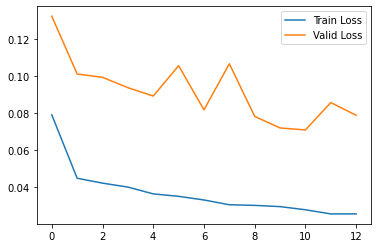

In [18]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.show()

In [19]:
train_predictions = lstm_ae0.predict(train_scaled)

2022-05-11 01:41:29.108453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:41:29.249946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:41:29.579030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:41:29.676529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:41:29.721243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
threshold = 0.2

In [21]:
train_error = []
for i in range(len(train_scaled)):
    if np.sqrt(np.mean(np.power(train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i] - train_scaled.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2])[i], 2))) > threshold:
        train_error.append(1)
    else:
        train_error.append(0)

In [22]:
train_error = pd.DataFrame(train_error, columns=['Prediction'])
train_error.value_counts()

Prediction
0             183842
1              26392
dtype: int64

In [23]:
err_index = list(train_error[train_error['Prediction'] == 1].index)

In [24]:
r_train = train.drop(err_index)
r_train.reset_index(drop=True, inplace=True)

# Prepare dataset for test

In [25]:
test = all_data[105120:]
test.reset_index(drop=True, inplace=True)

## Transform to sequence

In [26]:
trans_train = to_seq(r_train, step)
trans_test = to_seq(test, step)
print(trans_test.shape)

(105114, 5, 33)


In [27]:
train_seq = trans_train

## dimension down & feature scale

In [28]:
scaler = MinMaxScaler().fit(dimension_down(train_seq))
train_scaled = scaling(trans_train, scaler)
test_scaled = scaling(trans_test, scaler)
print(train_scaled.shape)
print(test_scaled.shape)

(183842, 5, 33)
(105114, 5, 33)


## LSTM AE for testset

In [29]:
def lstm_autoencoder2():
    feature_number = train_scaled.shape[2]
    lstm_ae = models.Sequential()

    # Encoding
    lstm_ae.add(layers.LSTM(64, input_shape=(step, feature_number), return_sequences=True))
    lstm_ae.add(layers.LSTM(32, return_sequences=False))
    lstm_ae.add(layers.RepeatVector(step))

    # Decoding
    lstm_ae.add(layers.LSTM(32, return_sequences=True))
    lstm_ae.add(layers.LSTM(64, return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(feature_number)))

    print(lstm_ae.summary())
    return lstm_ae

In [30]:
lstm_ae1 = lstm_autoencoder2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             25088     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 32)             8320      
                                                                 
 lstm_7 (LSTM)               (None, 5, 64)             24832     
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 33)            2145      
 tributed)                                            

In [31]:
# set parameter

epochs = 10
batch_size = 128
learning_rate = 0.001
validation = 0.2

In [32]:
# compile

lstm_ae1.compile(loss="mse", optimizer=optimizers.Adam(learning_rate))

In [33]:
# fit

history = lstm_ae1.fit(
    train_scaled,
    train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

Epoch 1/10


2022-05-11 01:45:03.773075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.152408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.202294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.280202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.337355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.402835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:04.470481: I tensorflow/core/grappler/optimizers/cust

   3/1150 [..............................] - ETA: 36s - loss: 0.0254  

2022-05-11 01:45:04.608612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1150/1150 [==============================] - ETA: 0s - loss: 8.7417e-04

2022-05-11 01:45:29.074660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:29.216370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:29.258243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:29.303404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:45:29.365726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1150/1150 [==============================] - 29s 23ms/step - loss: 8.7417e-04 - val_loss: 2.3324e-04
Epoch 2/10
1150/1150 [==============================] - 25s 22ms/step - loss: 1.5851e-04 - val_loss: 1.9677e-04
Epoch 3/10
1150/1150 [==============================] - 25s 22ms/step - loss: 1.2006e-04 - val_loss: 1.5221e-04
Epoch 4/10
1150/1150 [==============================] - 25s 22ms/step - loss: 1.0714e-04 - val_loss: 1.3630e-04
Epoch 5/10
1150/1150 [==============================] - 25s 22ms/step - loss: 1.0199e-04 - val_loss: 1.2380e-04
Epoch 6/10
1150/1150 [==============================] - 25s 22ms/step - loss: 9.8607e-05 - val_loss: 1.9786e-04
Epoch 7/10
1150/1150 [==============================] - 25s 22ms/step - loss: 9.6912e-05 - val_loss: 1.2028e-04
Epoch 8/10
1150/1150 [==============================] - 25s 22ms/step - loss: 9.3044e-05 - val_loss: 1.1630e-04
Epoch 9/10
1150/1150 [==============================] - 25s 22ms/step - loss: 8.6381e-05 - val_loss: 8.7072e-05
Epo

# detect anormal

## test mse loss

In [34]:
test_predictions = lstm_ae1.predict(test_scaled)

2022-05-11 01:49:19.274785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:49:19.400060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:49:19.500958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:49:19.575507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 01:49:19.619847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [50]:
threshold = 0.135

In [51]:
predict = []
for i in range(len(test_scaled)):
    if np.sqrt(np.mean(np.power(test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i] - test_scaled.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2])[i], 2))) > threshold:
        predict.append(1)
    else:
        predict.append(0)

In [52]:
predict = pd.DataFrame(predict, columns=['Prediction'])
predict.value_counts()

Prediction
0             104968
1                146
dtype: int64

In [53]:
predict[predict['Prediction']==1]

,Prediction
2227,1
2228,1
2229,1
2230,1
2231,1
...,...
75760,1
75761,1
75762,1
75763,1


In [54]:
predict.to_csv('predict0510_1.csv', mode='w')

In [55]:
np.sqrt(np.mean(np.power(test_predictions - test_scaled, 2), axis=1)).shape

(105114, 33)

In [56]:
pd.DataFrame(np.sqrt(np.mean(np.power(test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2]) - test_scaled.reshape(test_predictions.shape[0], test_predictions.shape[1] * test_predictions.shape[2]), 2), axis=1))).to_csv('rmse.csv', mode='w')

In [49]:
# 0.135 해보기

In [ ]:
lstm_ae1.